# Curso de Big Data

## Trabajo Práctico 4

### Samuel Arispe, Gonzalo Ochoa y Facundo Valle Quintana

### Reglas de formato y presentación
- El trabajo debe estar bien comentado (utilizando #) para que el código sea fácil de entender por sus compañeros y profesores.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
Domingo 26 de noviembre a las 23:59hs

### Contenidos:


Se profundizará el ejercicio de predicción de los hogares bajo la línea de pobreza para aquellos individuos que no reportan sus ingresos. Incluiremos nuevos métodos vistos en clase para clasificar a estos individuos.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub con el mensaje “Entrega final del tp”.

- Asegurense de haber creado una carpeta llamada TP4. Deben entregar un reporte (pdf) el código (jupyter notebook) dentro de esa carpeta

- También deben completar el link de su repositorio -para que pueda ser clonado y corregido- en la siguiente <a href="https://docs.google.com/spreadsheets/d/13MJzFrMygiMtAdYEhpW_Nu69Wvm57o5d/edit#gid=1820558252">google sheet</a>

- La última versión en el repositorio es la que será evaluada. Por lo que es importante que:
    - No completen la google sheet hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se  corregirán sus tareas hasta no ver el link en la google sheet.\
    
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija.

### Reglas de formato y presentación

- El trabajo se debe entregar como informe, junto con el código. Se espera una buena redacción en la resolución del práctico. La extensión máxima del informe es de 10 páginas.

- En el código, identifiquen claramente a qué inciso corresponde cada comando y, cuando sea necesario, usen bloques de texto para detallar sus respuestas.

- Importante: Todos los miembros del equipo deben haber hecho al menos un <i> commit </i> durante la realización del TP para asegurar que todos hayan aportado a su resolución.

## Parte I: Análisis de la base de hogares y cálculo de pobreza

Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH), asegúrense de estar calculando niveles de pobreza a nivel individual y a nivel de hogar similares a los que calcula el INDEC para la misma región. Además, asegúrense de estar realizando una limpieza de la base con mayor dedicación y entendimiento de sus variables.

#### 1. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama <i>usu_hogar_T123.xls</i>). Importen los datos de la encuesta de hogar y, al igual que en los trabajos anteriores, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(201)
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
#from ISLP import load_data
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score
from sklearn import datasets, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statistics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
# Cargamos la data
data_ind = pd.read_excel("usu_individual_T123.xlsx")
data_hog = pd.read_excel("usu_hogar_T123.xlsx")

In [4]:
#Filtrar datos para el área de Buenos Aires tanto a nivel individual como a nivel hogares
data_ind_baires = data_ind[data_ind['AGLOMERADO'].isin([32, 33])]
data_hog_baires = data_hog[data_hog['AGLOMERADO'].isin([32, 33])]

#### 2. Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense de estar usando las variables <i>CODUSU</i> y <i>NRO_HOGAR</i>.

In [5]:
#Unimos los dos dataframes
#Se incluirán todas las filas de ambos DataFrames, conservando todas las filas aunque no haya coincidencias en las columnas de unión
data_unida = pd.merge(data_ind_baires, data_hog_baires, on=['CODUSU','NRO_HOGAR'], how='outer')

# Seleccionar las columnas que tienen el sufijo a borrar
variables_duplicadas = data_unida.filter(like='_y', axis=1)

# Borrar las columnas seleccionadas del DataFrame
data_unida = data_unida.drop(variables_duplicadas.columns, axis=1)

#### 3. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

In [6]:
# Borramos todas las variables que tienen mas del 50% de missings
proporcion_missing_values = data_unida.isnull().mean()

# Filtra las columnas que tienen más del 50% de missing values
#   todas las variables relacionadas los desocupados tienen mas del 70% de NaN
#   todas las variables relacionadas a los ocupados tienen mas del 50% de NaN
#   Tambien eliminamos las variables relacionadas a la categoría otros y CH14 que se refiere al último año que aprobó, que es redundante dado que ya tenemos nivel educativo (NIVEL_ED).
columnas_50_missing = proporcion_missing_values[proporcion_missing_values > 0.5].index
print(columnas_50_missing)
# Eliminar las columnas seleccionadas del DataFrame
data_unida_drop50 = data_unida.drop(columnas_50_missing, axis=1)

data_unida_drop50['CH08'].fillna(9, inplace=True)
# Sólo reemplazamos esta variable con NS/NR  ya que solo tiene un missing value.
# P47T tiene 24 missing values pero es una variable de ingreso y luego será eliminada

data_unida_drop50['CH08'] = data_unida_drop50['CH08'].astype('int64')

Index(['CH14', 'CH15_COD', 'CH16_COD', 'IMPUTA', 'PP03C', 'PP03D', 'PP3E_TOT',
       'PP3F_TOT', 'PP03G', 'PP03H',
       ...
       'PDECINDR', 'IDECIFR_x', 'PDECIFR_x', 'IDECCFR_x', 'PDECCFR_x',
       'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP'],
      dtype='object', length=107)


In [7]:
variables_a_verificar = ['IV2','II1','IX_TOT','IX_MEN10','IX_MAYEQ10','ITF_x','CH06','CH12','NIVEL_ED']
# Vemos que CH6=Edad tiene valores negativos, por lo tanto se elimina esas observaciones
# Así como las observaciones que tienen 99 en variables numericas discretas que claramente son missing; menos la edad puede ser 99
data_unida_drop50[variables_a_verificar].describe().T

,count,mean,std,min,25%,50%,75%,max
IV2,7619.0,3.075338,1.933210,1.0,2.0,3.0,4.0,99.0
II1,7619.0,3.056307,1.928454,0.0,2.0,3.0,4.0,99.0
IX_TOT,7619.0,3.696417,1.852985,1.0,2.0,4.0,5.0,13.0
IX_MEN10,7619.0,0.601391,0.947037,0.0,0.0,0.0,1.0,8.0
IX_MAYEQ10,7619.0,3.095026,1.441937,1.0,2.0,3.0,4.0,10.0
ITF_x,7619.0,138407.892637,334941.671900,0.0,0.0,75000.0,200000.0,10990000.0
CH06,7619.0,37.177845,22.738454,-1.0,18.0,35.0,55.0,99.0
CH12,7619.0,4.093451,2.942823,0.0,2.0,4.0,6.0,99.0
NIVEL_ED,7619.0,3.799842,1.746307,1.0,3.0,4.0,5.0,7.0


<Axes: xlabel='variable', ylabel='value'>

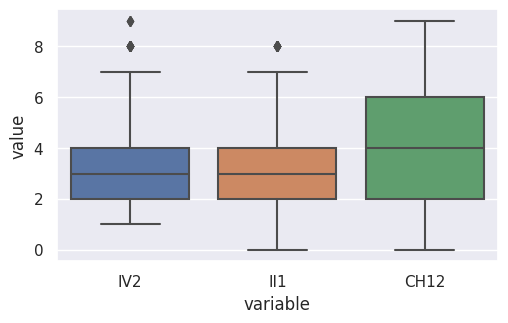

In [8]:
# Chequeamos variables numericas discretas con 99
variables_a_verificar = ['IV2','II1','CH12']  # Lista de variables a verificar
# Utiliza el método drop para eliminar las filas que cumplan con la condición
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[variables_a_verificar] == 99).any(axis=1)].index)

sns.set(rc={'figure.figsize':(5.7,3.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(data_unida_drop50[variables_a_verificar]))

In [9]:
# Obervaciones con valores negativos en variables que no corresponde
variables_negativas = ['CH06']
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[variables_negativas] < 0).any(axis=1)].index)

# Le damos formato de variables categóricas a las variables resepctivas con Sí, No, o categorías diferentes.

variables_categoricas = ['IV1','IV2','IV3','IV4','IV5','IV6','IV7','IV8','IV9','IV10',
                         'IV11','IV12_1','IV12_2','IV12_3','II3','II4_1','II4_2',
                         'II4_3','II5','II6','II7','II8','II9','V1','V2','V21',
                         'V22','V3','V4','V5','V6','V7','V8','V9','V10','V11',
                         'V12','V13','V14','V15','V16','V17','V18','V19_A','V19_B',
                         'CH03','CH04','CH07','CH08','CH09','CH10','CH11','CH13','CH15',
                         'CH16','ESTADO','CAT_OCUP','CAT_INAC','PP02C1','PP02C2',
                         'PP02C3','PP02C4','PP02C5','PP02C6','PP02C7','PP02C8',
                         'PP02E','PP02H','PP02I']

# Volvemos categóricas todas estas varaibles seleccionadas
data_unida_drop50[variables_categoricas] = data_unida_drop50[variables_categoricas].astype('category')
#data_unida_drop50[variables_categoricas].info()

for columna in variables_categoricas:
    dummies = pd.get_dummies(data_unida_drop50[variables_categoricas][columna], prefix=columna)
    data_unida_drop50 = pd.concat([data_unida_drop50, dummies], axis=1)

<Axes: xlabel='variable', ylabel='value'>

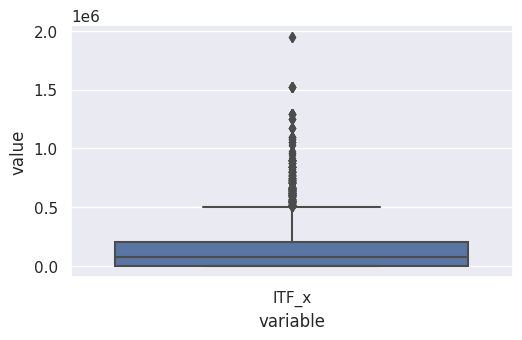

In [10]:
# De las variables de ingreso solo vemos la variable de ingreso total porque después se eliminarán todas las variables relacionadas a ingresos
# La variable de ingreso del hogar tiene outlier (10990000), que puede distorsionar todo. Solo eliminamos esas observaciones
ingreso = ['ITF_x']  # Lista de variables a verificar
data_unida_drop50 = data_unida_drop50.drop(data_unida_drop50[(data_unida_drop50[ingreso] >= 10990000).any(axis=1)].index)

sns.set(rc={'figure.figsize':(5.7,3.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(data_unida_drop50[ingreso]))

#### 4. Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes para predecir individuos bajo la línea de pobreza (por ejemplo, la proporción de niños en el hogar, si el cónyuge trabaja).

<Axes: xlabel='variable', ylabel='value'>

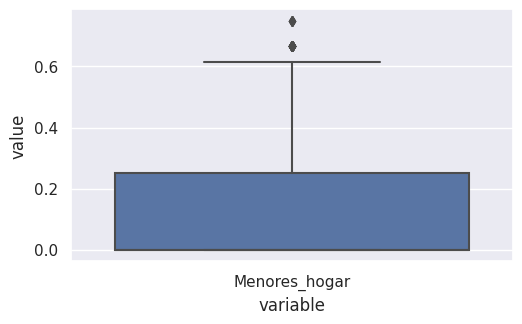

In [11]:
# Crear una nueva variable condicionada
resumen_hogar = ['IX_TOT','IX_MEN10','IX_MAYEQ10']
data_unida_drop50[resumen_hogar].describe().T
data_unida_drop50['Menores_hogar'] = data_unida_drop50['IX_MEN10']/data_unida_drop50['IX_TOT']
menores_hogar = ['Menores_hogar']
sns.set(rc={'figure.figsize':(5.7,3.27)})
sns.boxplot(x="variable", y="value", data=pd.melt(data_unida_drop50[menores_hogar]))

In [12]:
data_unida_drop50['CH03'].value_counts()
data_unida_drop50['Pareja_trabaja'] = ((data_unida_drop50['CH03'] == 2) & (data_unida_drop50['ESTADO'] == 1)).astype(int)
data_unida_drop50['Pareja_trabaja'].value_counts()

0    6702
1     858
Name: Pareja_trabaja, dtype: int64

#### 5. Presenten un gráfico (que no sea de barras) para describir la interacción o correlación entre dos o más variables.

<Axes: title={'center': 'Pearson Correlation of Features'}>

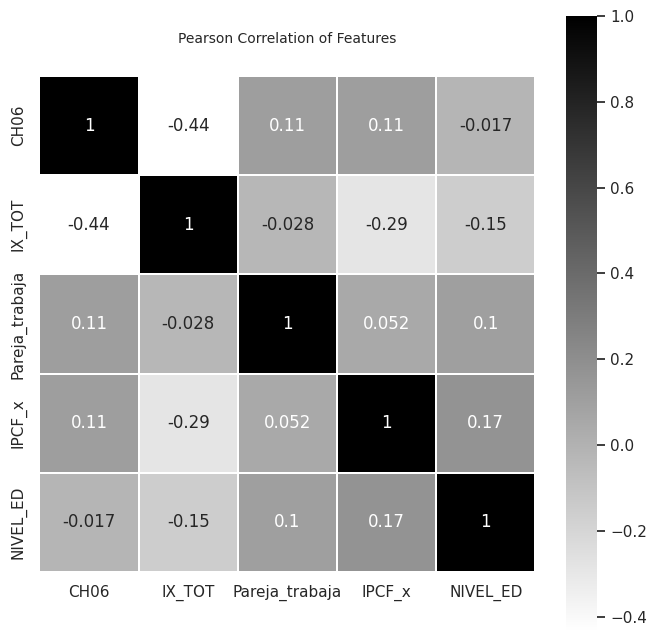

In [13]:
variables = ['CH06', 'IX_TOT', 'Pareja_trabaja', 'IPCF_x', 'NIVEL_ED']
colormap = plt.cm.gist_gray_r
plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=10)
sns.heatmap(data_unida_drop50[variables].astype(float).corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap=colormap,
            linecolor='white',
            annot=True)

Realizamos una correlación entre las variables 'CH06', 'IX_TOT', 'Pareja_trabaja', 'IPCF_x', 'NIVEL_ED'.


Podemos ver que una correlación negativa entre la cantidad total de miembros del hogar (IX_TOT) y y la edad de los encuestados, lo que tiene sentido económico.

Otra correlación interesante es la de Ingreso Capital per Capita Familiar (IPCF_x) y la cantidad de miembros del hogar (IX_TOT), lo que una vez más tiene sentido (algebraícamente).

#### 6. Construyan la <i>columna_adulto_equiv</i> y la columna <i>ad_equiv_hogar</i> y luego dividan la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado respondieron) y otro conserve a las personas que no reportaron ITF (llamado norespondieron). Además, agreguen a la base respondieron una columna llamada <i>ingreso_necesario</i> que sea el producto de la canasta básica por <i>ad_equiv_hogar</i>. Agreguen a la base respondieron una columna llamada <i>pobre</i>, que tome valor 1 si el ITF es menor al <i>ingreso_necesario</i> que necesita esa familia y 0 en caso contrario.

In [14]:
#cargamos los datos y renombramos las columnas
data_adult=pd.read_excel("tabla_adulto_equiv.xlsx", header = 4, nrows=23, ) #formateamos para que se cargue correctamente la base.
data_adult.rename({'Unnamed: 0':'Edad','Unnamed: 1':'Mujeres','Unnamed: 2':'Hombres'}, axis=1, inplace = True) # Renombramos las columnas.

In [15]:
def calcular_adulto_equiv(sexo, edad): # Esta función toma dos argumentos: el sexo y la edad. Mediante un "if" filtra primero por sexo y luego por edad, para devolvernos el valor de adulto equivalente correspondiente.
    # para los hombres:
    if sexo == 1:
        if edad < 1:
            return 0.35
        elif edad == 1:
            return 0.37
        elif edad == 2:
            return 0.46
        elif edad == 3:
            return 0.51
        elif edad == 4:
            return 0.55
        elif edad == 5:
            return 0.6
        elif edad == 6:
            return 0.64
        elif edad == 7:
            return 0.66
        elif edad == 8:
            return 0.68
        elif edad == 9:
            return 0.69
        elif edad == 10:
            return 0.79
        elif edad == 11:
            return 0.82
        elif edad == 12:
            return 0.85
        elif edad == 13:
            return 0.90
        elif edad == 14:
            return 0.96
        elif edad == 15:
            return 1
        elif edad == 16:
            return 1.03
        elif edad == 17:
            return 1.04
        elif 18 <= edad <= 29:
            return 1.02
        elif 30 <= edad <= 45:
            return 1.00
        elif 46 <= edad <= 60:
            return 1.00
        elif 61 <= edad <= 75:
            return 0.83
        elif edad > 75:
            return 0.74
        else:
            print("hay un problema")

    # Para las mujeres:
    elif sexo == 2:
        if edad < 1:
            return 0.35
        elif edad == 1:
            return 0.37
        elif edad == 2:
            return 0.46
        elif edad == 3:
            return 0.51
        elif edad == 4:
            return 0.55
        elif edad == 5:
            return 0.6
        elif edad == 6:
            return 0.64
        elif edad == 7:
            return 0.66
        elif edad == 8:
            return 0.68
        elif edad == 9:
            return 0.69
        elif edad == 10:
            return 0.70
        elif edad == 11:
            return 0.72
        elif edad == 12:
            return 0.74
        elif edad == 13:
            return 0.76
        elif edad == 14:
            return 0.76
        elif edad == 15:
            return 0.77
        elif edad == 16:
            return 0.77
        elif edad == 17:
            return 0.77
        elif 18 <= edad <= 29:
            return 0.76
        elif 30 <= edad <= 45:
            return 0.77
        elif 46 <= edad <= 60:
            return 0.76
        elif 61 <= edad <= 75:
            return 0.67
        elif edad > 75:
            return 0.63
        else:
            print("hay un problema")

# Ahora aplicamos la función a nuestro dataframe, y guardamos el valor que nos arroja la función en una nueva columna.
data_unida_drop50['adulto_equiv'] = data_unida_drop50.apply(lambda row: calcular_adulto_equiv(row['CH04'], row['CH06']), axis=1).copy()

In [16]:
# Agrupamos los datos por "CODUSU" y "NRO_HOGAR,"
# Calculamos la suma del valor del adulto equivalente en cada grupo de hogares
# Agrega ese valor como una nueva columna
data_unida_drop50["ad_equiv_hogar"] = data_unida_drop50.groupby(['CODUSU', 'NRO_HOGAR'])["adulto_equiv"].transform('sum')

In [17]:
# Guardamos un dataframe con los datos de las personas que si contestaron.

respondieron = data_unida_drop50[data_unida_drop50["ITF_x"]!=0]

# Guardamos en otro data frame las personas que no respondieron.

norespondieron = data_unida_drop50[data_unida_drop50["ITF_x"]==0]

In [18]:
#Calculamos un valor basado en el valor del adulto equivalente en el hogar.
def CBT (ad_equiv_hogar):
    return ad_equiv_hogar * 57371.05

#Creamos una Nueva Columna llamada "ingreso_necesario":
respondieron['ingreso_necesario'] = respondieron.apply(lambda row: CBT(row['ad_equiv_hogar']), axis=1).copy()

#Esta función nos indica las personas pobres, cuyo ingreso es menor al necesario.
def polenta(hornero, hornero_necesario):
    if hornero < hornero_necesario:
        return 1
    else:
        return 0

respondieron['pobre'] = respondieron.apply(lambda row: polenta(row['ITF_x'], row['ingreso_necesario']), axis=1)

respondieron['pobre'].value_counts()

<ipython-input-18-9265e68da398>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['ingreso_necesario'] = respondieron.apply(lambda row: CBT(row['ad_equiv_hogar']), axis=1).copy()
<ipython-input-18-9265e68da398>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['pobre'] = respondieron.apply(lambda row: polenta(row['ITF_x'], row['ingreso_necesario']), axis=1)


0    2618
1    1555
Name: pobre, dtype: int64

#### 7. Para calcular la tasa de hogares bajo la línea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Lograron que se asemeje al porcentaje que reporta el  <a href="https://www.indec.gob.ar/uploads/informesdeprensa/eph_pobreza_09_2326FC0901C2.pdf">INDEC en sus informes?</a>

In [19]:
#Creamos base con solo una observacion por hogar
respondieron_hogares=respondieron.groupby(['CODUSU','NRO_HOGAR']).agg({"pobre" : "mean","PONDERA_x" : "mean"})
#Sumamos cuanto hay de cada uno.
sumas=respondieron_hogares.groupby("pobre").PONDERA_x.sum().to_frame()
respondieron_porcentajes = sumas.apply(lambda x:
                                                 100 * x / float(x.sum()))
print(respondieron_porcentajes)

       PONDERA_x
pobre           
0.0    71.534989
1.0    28.465011


Usando nuestro procedimiento encontramos un 28.46% de hogares bajo para el GBA en comparación con el 30,3%; una estimación bastante acertada!


## Parte II: Construcción de funciones

El objetivo de esta parte del trabajo es revisar y mejorar el código que escribieron en la parte II del TP3. Deben buscar que sea flexible y esté modularizado (en funciones bien documentadas con docstrings). De esta forma, evitarán repetir código y podrán utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos personales a futuro).

#### 1. Escriban una función, llamada <i>evalua_metodo</i>, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (<i>X train </i>, <i> y train </i> , <i>X test</i>, <i>y test</i>). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar verdaderos positivos, verdaderos negativos, falsos positivos, falsos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.

In [20]:
def evalua_metodo(X_train, X_test, Y_train, Y_test, modelo, vecinos=2, depth=1, b_estimators=5, features=2):
    '''
    La función ajusta el modelo con los datos de entrenamiento (x_train, y_train) y
    calcular la matriz de confusión, los valores de
    AUC asociados, el Accuracy score de cada método, asi como la precisión y el ECM).

    Input:

        x_train: Datos de entrenamiento (características) - Conjunto de entrenamiento.
        x_test: Datos de prueba (características) - Conjunto de prueba.
        y_train: Etiquetas de entrenamiento - Valores objetivo del conjunto de entrenamiento.
        y_test: Etiquetas de prueba - Valores objetivo del conjunto de prueba.
        modelo: Modelo de clasificación a evaluar (por ejemplo, LogisticRegression, LinearDiscriminantAnalysis, KNeighborsClassifier,
        DecisionTreeClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier).
        vecinos=2: Parámetro vecinos (número de vecinos mas cercanos) para ajustar el modelo (por defecto, 2).

    Output:

        df_metrics: DataFrame que contiene la matriz de confusión,  AUC, la precisión (Accuracy), precision,
        y el error cuadrático medio (ECM).
    '''

    if modelo== LogisticRegression:
        y = modelo(max_iter=10000).fit(X_train, Y_train)
    elif modelo== KNeighborsClassifier:
        y = modelo(n_neighbors=vecinos).fit(X_train, Y_train)
    elif modelo==LinearDiscriminantAnalysis:
        y = modelo().fit(X_train, Y_train)
    elif modelo==DecisionTreeClassifier:
        y = modelo(max_depth = depth).fit(X_train, Y_train)
    elif modelo==BaggingClassifier:
        y = modelo(n_estimators=b_estimators, max_samples=200, random_state=201).fit(X_train, Y_train)
    elif modelo==RandomForestClassifier:
        y = modelo(n_estimators=50, max_samples=200, max_features=features, random_state=201).fit(X_train, Y_train)
    elif modelo==AdaBoostClassifier:
        y = modelo(n_estimators=20, random_state=201).fit(X_train, Y_train)
    else:
        y = modelo.fit(X_train, Y_train)

    Y_pred = y.predict(X_test)

    matriz_confusion = confusion_matrix(Y_test, Y_pred)

    tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()

    auc = roc_auc_score(Y_test, Y_pred)

    accuracy = accuracy_score(Y_test, Y_pred)

    precision = tp/(tp + fp)

    ecm = mean_squared_error(Y_test, Y_pred)

    df_metrics = pd.DataFrame({'modelo': [modelo], 'matriz de confusion':[matriz_confusion], 'auc':['{:.3f}'.format(auc)], 'accuracy': ['{:.3f}'.format(accuracy)], 'precision':['{:.3f}'.format(precision)] , 'ecm':[ecm]})

    return df_metrics

#### 2. Escriban una función, llamada <i>cross_validation</i>, que realice validación cruzada con <i>k</i> iteraciones (<i>k</i>-fold CV), llamando a la función del inciso anterior en cada una, pero para las <i>k</i> distintas particiones. La función debe recibir como argumentos el modelo, el valor de <i>k</i> y un dataset (es decir, sólo X e y [1]). Pueden ayudarse con la función  <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">Kfold</a> para generar las particiones necesarias.

[1] Cuando usen esta función en la parte III del TP asegurense de pasar <i>X_train</i> e <i>y_train</i> para no utilizar las observaciones de test en esta instancia de validación.

In [21]:
def cross_validation(modelo, k, X_train, Y_train):
    '''
    Esta función aplica la validación cruzada con k iteraciones (k-fold CV), llamando a la función
    "evalua_metodo" cada iteración, pero para las k distintas particiones.

 Inputs:

    modelo: Modelo de clasificación a evaluar (por ejemplo,  LogisticRegression, LinearDiscriminantAnalysis, KNeighborsClassifier,
        DecisionTreeClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier).
    k: Número de divisiones en la validación cruzada (k-fold CV).
    X_train: Conjunto de datos de características de entrada.

    Outputs:

    final_ecm: Error cuadrático medio promedio a través de las k iteraciones de validación cruzada.
    ecm: Lista que contiene el error cuadrático medio de cada iteración de validación cruzada.

    '''
    sc = StandardScaler()

    kf = KFold(n_splits=k, shuffle=True, random_state=201)

    ecm = []

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        x_train, x_test = X_train.iloc[list(train_index)], X_train.iloc[list(test_index)]
        y_train, y_test = Y_train.iloc[list(train_index)], Y_train.iloc[list(test_index)]

        # Estandarizamos las observaciones de entrenamiento
        X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
        # Estandarizamos las observaciones de test
        X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)

        ecm2 = evalua_metodo(X_train_transformed, X_test_transformed, y_train, y_test, modelo) #Aplicamos la función evalua_metodo
        ecm3 = ecm2['ecm'][0]
        ecm.append(ecm3) # Agregamos los resultados

    final_ecm = statistics.mean(ecm) # Computamos las medias.

    return final_ecm, ecm

#### 3. Escriban una función, llamada <i>evalua_config</i> que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrían codificarse en diccionarios de Python) y utilizando la función <i>cross_validation</i> obtenga el error [2] promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error. Asegúrense de que esta función sirva para cualquier hiperpar´ametro que quieran elegir por crossvalidation para cualquier modelo.

Notas:

[2] Utilicen la medición del error que prefieran. Una opción sería el Error Cuadrático Medio

In [34]:
def evalua_config(modelo, vecinos, depth, b_estimators, features, k, X_train, Y_train):
    '''
    Esta función reciba una lista con las configuración de lambda y de las particiones.
    Luego, utilizando la función cross_validation, obtiene el Error Promedio para cada configuración.

    Inputs:

    vecinos: número de vecinos más cercanos en KNeighborsClassifier
    depth: profundidad del árbol, cantidad de nodos en DecisionTreeClassifier
    b_estimators: número de muestras en BaggingClassifier
    features: cantidad de variables en RandomForestClassifier
    k: Número de divisiones en la validación cruzada (k-fold CV) para evaluar cada configuración.
    X_train: Conjunto de datos de características de entrada.
    y_train: Etiquetas de salida correspondientes al conjunto de datos de entrada.

    Outputs:

    minimo_ecm_mean: El valor mínimo del error cuadrático medio promedio encontrado en las configuraciones.
    valor_parametro: El valor del numero de vecinos que corresponde al mínimo error cuadrático medio promedio.
    ret: DataFrame que contiene los resultados de ECM y ECM promedio para cada configuración del numero de vecinos.
    '''

    ret=pd.DataFrame(columns=["ecm","ecm_mean","parametro"])

    if modelo==KNeighborsClassifier:
        for i in range(len(vecinos)):
            clf_en_LR = modelo(n_neighbors=vecinos[i])
            ecm_mean  = cross_validation(clf_en_LR, k, X_train, Y_train)[0]
            ecm       = cross_validation(clf_en_LR, k, X_train, Y_train)[1]
            ret.loc[i]= [ecm, ecm_mean, vecinos[i]]
    elif modelo==DecisionTreeClassifier:
        for i in range(len(depth)):
            clf_en_LR = modelo(max_depth = depth[i], random_state=201)
            ecm_mean  = cross_validation(clf_en_LR, k, X_train, Y_train)[0]
            ecm       = cross_validation(clf_en_LR, k, X_train, Y_train)[1]
            ret.loc[i]= [ecm, ecm_mean, depth[i]]
    elif modelo==BaggingClassifier:
        for i in range(len(b_estimators)):
            clf_en_LR = modelo(n_estimators=b_estimators[i], max_samples=200, random_state=201)
            ecm_mean  = cross_validation(clf_en_LR, k, X_train, Y_train)[0]
            ecm       = cross_validation(clf_en_LR, k, X_train, Y_train)[1]
            ret.loc[i]= [ecm, ecm_mean, b_estimators[i]]
    elif modelo==RandomForestClassifier:
        for i in range(len(features)):
            clf_en_LR = modelo(n_estimators=50, max_samples=200, max_features=features[i], random_state=201)
            ecm_mean  = cross_validation(clf_en_LR, k, X_train, Y_train)[0]
            ecm       = cross_validation(clf_en_LR, k, X_train, Y_train)[1]
            ret.loc[i]= [ecm, ecm_mean, features[i]]

    indice_minimo_ecm = ret['ecm_mean'].idxmin()
    valor_parametro = ret.at[indice_minimo_ecm, 'parametro']
    minimo_ecm_mean = ret['ecm_mean'].min()

    return minimo_ecm_mean, valor_parametro

#### 4. Escriban una función llamada <i>evalua_multiples_metodos</i> que les permita implementar los siguiente métodos que se enumeran a continuación. Esta función debe utilizar su función <i>evalua_config</i> para optimizar los parámetros que ustedes decidan (de mínima deben optimizar el K -cantidad de vecinos- para el modelo KNN). Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función <i>evalua_metodo</i> y las filas sean los modelos (con su configuraci´on de hiperparámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperpar´ametros/configuración [3]:



- Regresión logística
- Análisis de discriminante lineal
- KNN
- Árbol de decisión
- Bagging
- Random Forests
- Boosting

Notas:

[3] Pista: Para los modelos que elijan optimizar sus hiperparámetros (ej. KNN), observen que deberán correr la función evalua metodo dos veces. Una para optimizar los hiperparámetros (con el set de datos para train, que será dividido nuevamente en train y validación) y otra, para obtener las métricas con el hiperparámetro óptimo obtenido (con un set de datos para train y otro para test).

In [29]:
def evalua_multiples_metodos(k, vecinos_max, depth_max, b_estimators_max, features_max, X_train, X_test , Y_train, Y_test): #X_train, X_test , Y_train, Y_test
    '''
    Esta última función permite implementar los métodos de regresión logística, K vecinos más cercanos, Análisis Discriminante, Árboles de decisión, Bagging,
    Random Forest y boosting con los hiperparámetros elegidos.

    Para la regresión logística, utilizamos la función "evalua_config" para optimizar el λ
    de la regularización.

    El output de la función es un dataframe donde las columnas son las métricas de la función
    "evalua_metodo" y las filas corresponden a los modelos (con su configuración de hiperparámetros
    asociada).

    Inputs:

    k: Número de divisiones en la validación cruzada (k-fold CV) para evaluar cada modelo.
    vecinos_max: Valor máximo de vecinos (parámetro de número de vecinos más cercanos) a considerar.
    X: Conjunto de datos de características de entrada.
    y: Etiquetas de salida correspondientes al conjunto de datos de entrada.

    Outputs:

    matriz: DataFrame que contiene las métricas de rendimiento para cada modelo y configuración de
    hiperparámetros.
    '''


    modelos = ['Regresion logistica','K vecinos mas cercanos','Analisis discriminante','Arbol de decision','Bagging','Random Forest','Boosting']

    vecinos = np.arange(2, vecinos_max,1).tolist()
    depth = np.arange(1, depth_max,1).tolist()
    b_estimators = np.arange(1, b_estimators_max,1).tolist()
    features = np.arange(1, features_max,1).tolist()

    matriz = pd.DataFrame(columns=["Modelo","Hiperparametro","Matriz de confusion","AUC","Accuracy","Precisión","ECM"])

    for modelo in modelos:
        if modelo == 'Regresion logistica':
            metricas_log= evalua_metodo(X_train, X_test , Y_train, Y_test , LogisticRegression)
            results = [modelo,      "-"     , metricas_log['matriz de confusion'][0],metricas_log['auc'][0], metricas_log['accuracy'][0], metricas_log['precision'][0], metricas_log['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo =='K vecinos mas cercanos':
            vecinos_optimo = evalua_config(KNeighborsClassifier, vecinos, depth,b_estimators,features, k , X_train, Y_train)[1] #hiperparametro vecinos
            metricas_knn = evalua_metodo(X_train, X_test , Y_train, Y_test, KNeighborsClassifier, vecinos=vecinos_optimo)
            results = [modelo, vecinos_optimo ,metricas_knn['matriz de confusion'][0],metricas_knn['auc'][0], metricas_knn['accuracy'][0], metricas_knn['precision'][0], metricas_knn['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo == 'Analisis discriminante':
            metricas_lda = evalua_metodo(X_train, X_test , Y_train, Y_test, LinearDiscriminantAnalysis)
            results = [modelo,    1        ,metricas_lda['matriz de confusion'][0], metricas_lda['auc'][0], metricas_lda['accuracy'][0], metricas_lda['precision'][0], metricas_lda['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo == 'Arbol de decision':
            depth_optimo = evalua_config(DecisionTreeClassifier, vecinos, depth,b_estimators,features, k , X_train, Y_train)[1] #hiperparametro depth
            metricas_tree = evalua_metodo(X_train, X_test , Y_train, Y_test, DecisionTreeClassifier, depth=depth_optimo)
            results = [modelo,  depth_optimo , metricas_tree['matriz de confusion'][0],metricas_tree['auc'][0], metricas_tree['accuracy'][0], metricas_tree['precision'][0], metricas_tree['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo == 'Bagging':
            b_estimators_optimo = evalua_config(BaggingClassifier, vecinos, depth, b_estimators, features, k , X_train, Y_train)[1] #hiperparametro b_estimators
            metricas_bag = evalua_metodo(X_train, X_test , Y_train, Y_test, BaggingClassifier, b_estimators=b_estimators_optimo)
            results = [modelo,  b_estimators_optimo ,metricas_bag['matriz de confusion'][0], metricas_bag['auc'][0], metricas_bag['accuracy'][0], metricas_bag['precision'][0], metricas_bag['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo == 'Random Forest':
            features_optimo = evalua_config(RandomForestClassifier, vecinos, depth, b_estimators, features, k , X_train, Y_train)[1] #hiperparametro features
            metricas_rand = evalua_metodo(X_train, X_test , Y_train, Y_test, RandomForestClassifier, features=features_optimo)
            results = [modelo,  features_optimo , metricas_rand['matriz de confusion'][0],metricas_rand['auc'][0], metricas_rand['accuracy'][0], metricas_rand['precision'][0], metricas_rand['ecm'][0]]
            matriz.loc[len(matriz)] = results

        elif modelo == 'Boosting':
            metricas_boost = evalua_metodo(X_train, X_test , Y_train, Y_test, AdaBoostClassifier)
            results = [modelo,    "-"       , metricas_boost['matriz de confusion'][0],metricas_boost['auc'][0], metricas_boost['accuracy'][0], metricas_boost['precision'][0], metricas_boost['ecm'][0]]
            matriz.loc[len(matriz)] = results

    return(matriz)

## Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cuánto ganan.

#### 1. Eliminen de ambas bases (<i>respondieron</i>, <i>norespondieron</i>) todas las variables relacionadas a ingresos (en el archivo <a href = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_1T2023.pdf" > Diseño de bases y estructura </a> ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas <i>adulto_equiv</i>, <i>ad_equiv_hogar</i> e <i>ingreso_necesario</i>. Establezcan a la variable pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X).

In [30]:
# Identificamos las columnas a droppear.

drop_gang = ['CODUSU','ANO4_x','TRIMESTRE_x','NRO_HOGAR','COMPONENTE','H15','REGION_x',
            'AGLOMERADO_x','PONDERA_x','MAS_500_x','REALIZADA','CH05','ITF_x','DECIFR_x',
            'RDECIFR_x','GDECIFR_x','ADECIFR_x','IPCF_x','DECCFR_x','RDECCFR_x',
            'GDECCFR_x','ADECCFR_x','PONDIH_x','P21','DECOCUR','RDECOCUR','GDECOCUR',
            'ADECOCUR','PONDIIO','TOT_P12','P47T','DECINDR','RDECINDR','GDECINDR',
            'ADECINDR','PONDII',"V2_M","V3_M","V4_M","V5_M","V8_M","V9_M","V10_M",
            "V11_M","V12_M","V18_M","V19_AM","V21_M","T_VI",'adulto_equiv','ad_equiv_hogar',
            'ingreso_necesario',
            'IV1','IV2','IV3','IV4','IV5','IV6','IV7','IV8','IV9','IV10',
            'IV11','IV12_1','IV12_2','IV12_3','II3','II4_1','II4_2','II4_3','II5',
            'II6','II7','II8','II9','V1','V2','V21','V22','V3','V4','V5','V6','V7',
            'V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19_A','V19_B',
            'VII1_1','VII1_2','VII2_1','VII2_2','VII2_3','VII2_4','CH03','CH04','CH07',
            'CH08','CH09','CH10','CH11','CH13','CH15','CH16','ESTADO','CAT_OCUP',
            'CAT_INAC','PP02C1','PP02C2','PP02C3','PP02C4','PP02C5','PP02C6','PP02C7',
            'PP02C8','PP02E','PP02H','PP02I']


# Eliminamos las variables de ambos dataframes 'respondieron' y 'norespondieron'.

respondieron_drop = respondieron.drop(drop_gang, axis=1)

#### 2. Corran la función evalua múltiples metodos con la base respondieron.Asegúrense de estar utilizando su función de <i>evalua_config</i> para optimizar algunos hiperparámetros (de mínima, el K en el modelo KNN).

In [31]:
# Hago esto solo para probar, porque cada train y test se creará/particionará por CV

# Asignamos las variables que serán predictores y la predicha
y = respondieron_drop.loc[:, respondieron_drop.columns == "pobre"]
X = respondieron_drop.loc[:, respondieron_drop.columns != "pobre"]

# Agregamos la columna con 1s

X['intercepto'] = 1

# Lo colocamos al principio

X = X[['intercepto'] + [col for col in X if col != 'intercepto']]

#len(X.columns)

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=201)

In [35]:
# Realizamos una prueba con hiperparámetros definidos.

evalua_multiples_metodos(5, 10, 40, 100, 50 ,X_train, X_test , Y_train, Y_test) # X_train, X_test , Y_train, Y_test

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

,Modelo,Hiperparametro,Matriz de confusion,AUC,Accuracy,Precisión,ECM
0,Regresion logistica,-,"[[702, 92], [131, 327]]",0.799,0.822,0.780,0.178115
1,K vecinos mas cercanos,3,"[[720, 74], [197, 261]]",0.738,0.784,0.779,0.216454
2,Analisis discriminante,1,"[[714, 80], [142, 316]]",0.795,0.823,0.798,0.177316
3,Arbol de decision,21,"[[716, 78], [90, 368]]",0.853,0.866,0.825,0.134185
4,Bagging,62,"[[714, 80], [135, 323]]",0.802,0.828,0.801,0.171725
5,Random Forest,39,"[[725, 69], [155, 303]]",0.787,0.821,0.815,0.178914
6,Boosting,-,"[[693, 101], [143, 315]]",0.780,0.805,0.757,0.194888


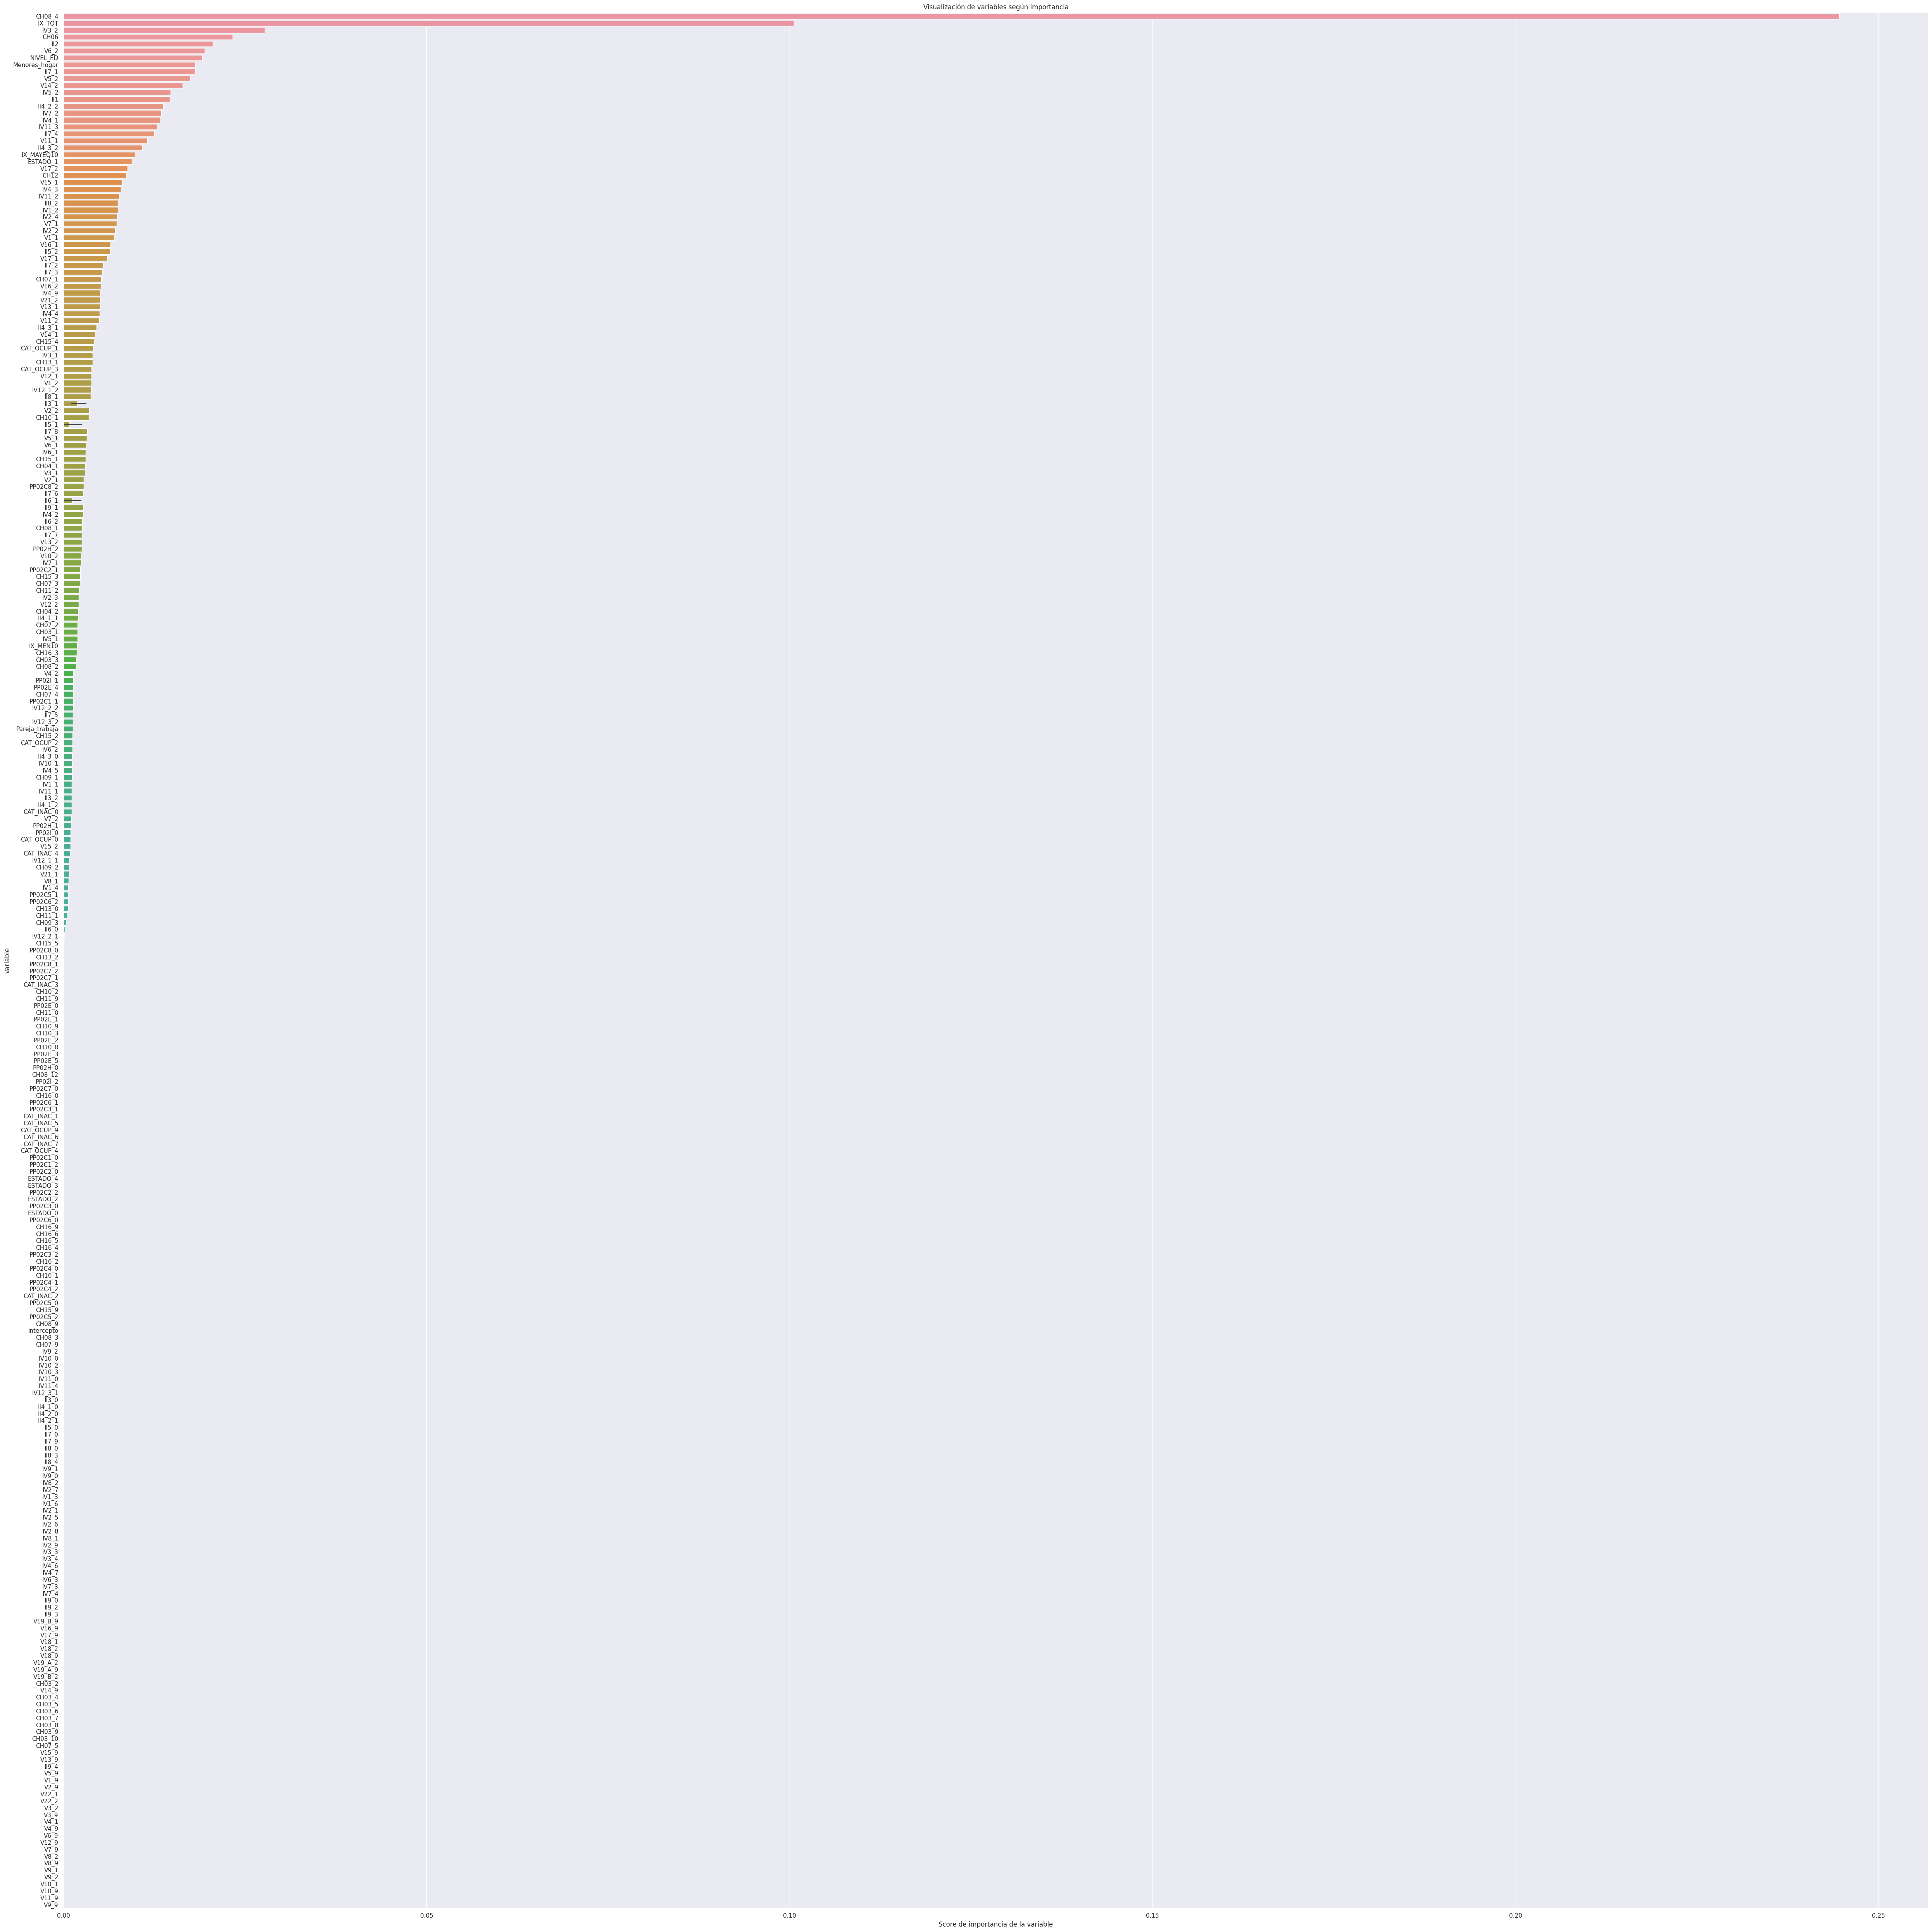

In [36]:
feature_imp = pd.Series(DecisionTreeClassifier(max_depth = 21, random_state=201).fit(X_train, Y_train).feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(50,50))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score de importancia de la variable')
plt.ylabel('variable')
plt.title("Visualización de variables según importancia")
plt.tight_layout()

Para el método de árboles de decisión, las variables que encontramos que son más relevantes son CH08_4, IX_TOT, IV3_2, CH06, NIVEL_ED, Menores_hogar, II7_1.



<ipython-input-37-d0f67857b94a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  feature_imp = pd.Series(RandomForestClassifier(n_estimators=50, max_samples=200, max_features=39, random_state=201).fit(X_train, Y_train).feature_importances_, index=X_train.columns).sort_values(ascending=False)


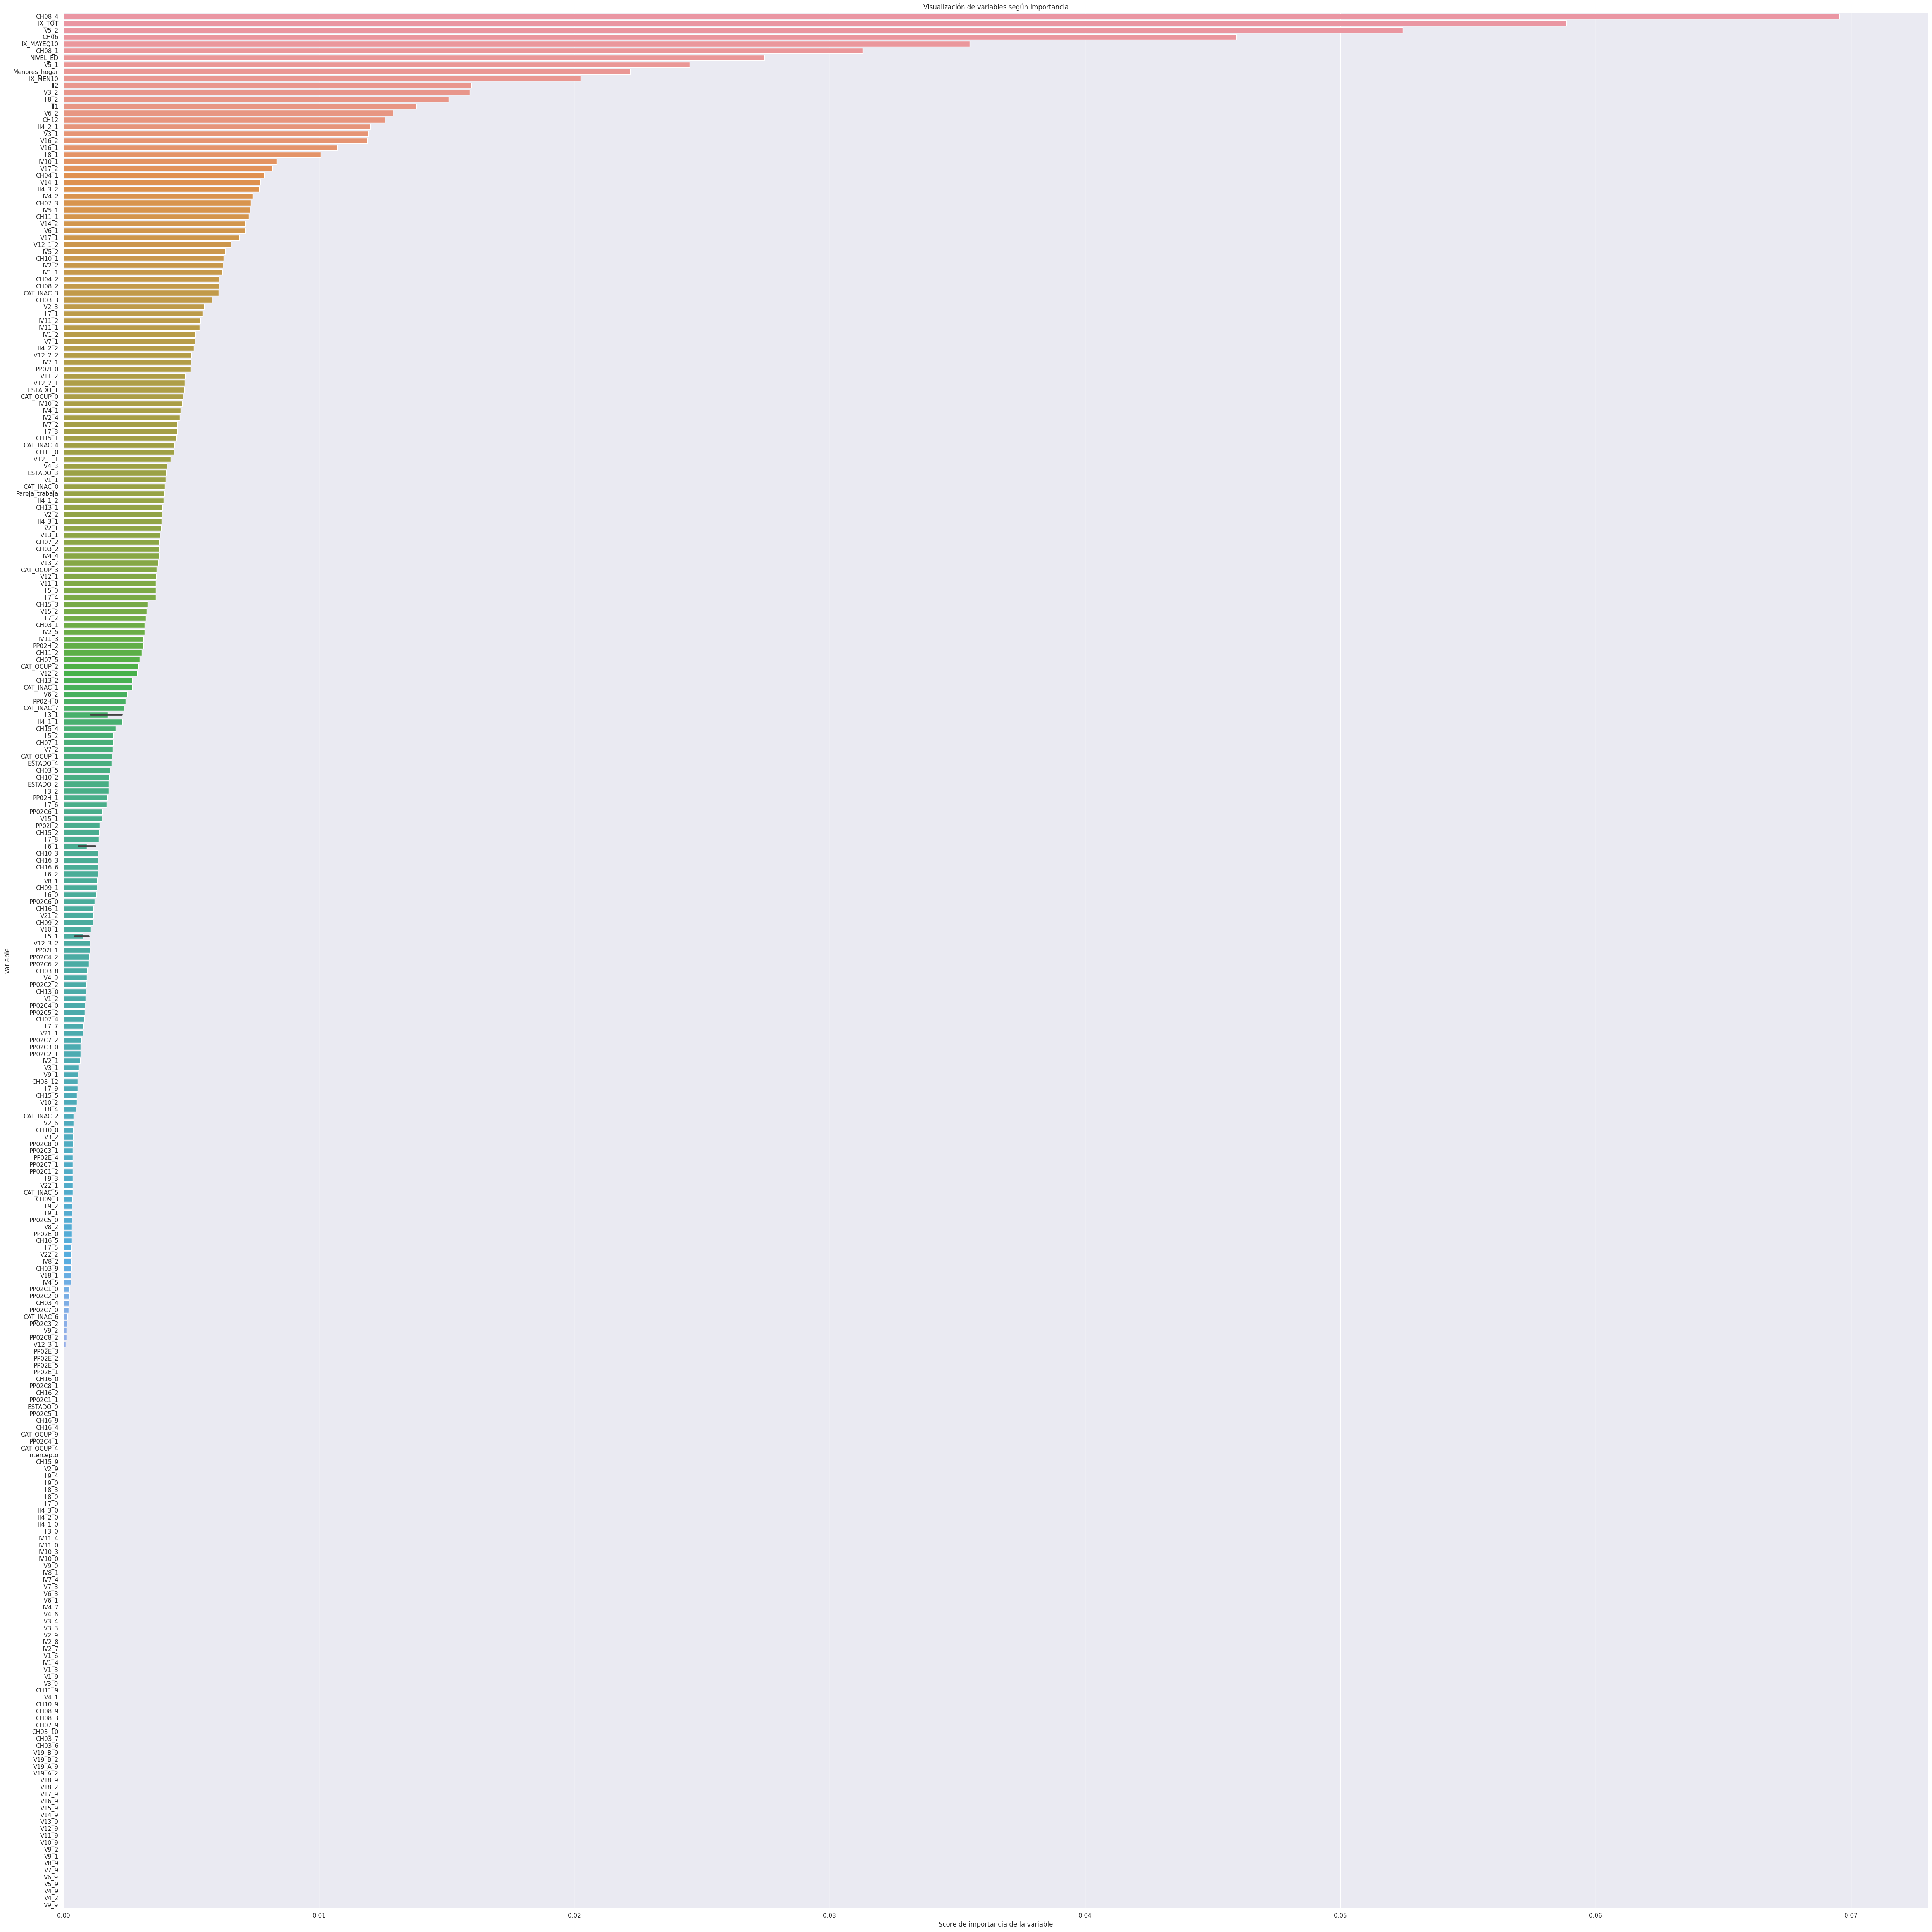

In [37]:
feature_imp = pd.Series(RandomForestClassifier(n_estimators=50, max_samples=200, max_features=39, random_state=201).fit(X_train, Y_train).feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(50,50))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score de importancia de la variable')
plt.ylabel('variable')
plt.title("Visualización de variables según importancia")
plt.tight_layout()

Para el método de random forest, las variables que encontramos que son más relevantes son IX_TOT, CH06_4, V5_2, CH06, Menores_hogar, V5_1.



#### 3. ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen mencionando las métricas que conocen.

En nuestro caso, vemos que el modelo con mejor capacidad predictiva es el de <b>Árbol de decisión</b> con una profundidad de valor <b>21</b> con <b>AUC 85.3% </b> y y un <b>accuracy de 86.6%</b> y una <b>precisión de 82.5%</b> y un <b>ECM de 0.13</b>. \n

Luego le sigue en Bagging con <b> 62 </b> muestras como el número óptimo, un <b>ECM de 0.172</b> y un <b>accuracy de 83.5%</b>.

#### 4. ¿Lograron mejorar sus predicción respecto al TP3 [4]?

Notas:

[4] Si crearon variables relevantes en el ejercicio 4 parte I, se esperaría que sus modelos mejoren su predicción.

En comparación con el TP3, podemos ver que nuestros métodos se volvieron en general más precisos:

Para la regresión logística, vemos que un leve empeoramiento en las métricas de la segunda versión estimada en el TP3, pero mejoras respecto a su primera versión.

Para el método de KNN, vemos leves mejoras en ECM y accuracy con el mismo hiperparámetro.

Para el el método LDA, vemos la misma precisión pero empeoramiento de la AUC y el ECM, pero la misma accuracy.

<table border="1">
  <thead>
    <tr>
      <th colspan="6">TP3</th>
    </tr>
    <tr>
      <th>Modelo</th>
      <th>Hiperparámetro</th>
      <th>Matriz de confusión</th>
      <th>Precisión / Accuracy</th>
      <th>AUC</th>
      <th>ECM</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Regresión logística</td>
      <td>10.01</td>
      <td>[[703, 91], [137, 321]]</td>
      <td>0.818</td>
      <td>0.895</td>
      <td>0.182109</td>
    </tr>
    <tr>
      <td>K vecinos más cercanos</td>
      <td>3.00</td>
      <td>[[714, 80], [203, 255]]</td>
      <td>0.774</td>
      <td>0.809</td>
      <td>0.226038</td>
    </tr>
    <tr>
      <td>Análisis discriminante</td>
      <td>1.00</td>
      <td>[[719, 75], [146, 312]]</td>
      <td>0.823</td>
      <td>0.895</td>
      <td>0.176518</td>
    </tr>
    <tr>
      <td>Ridge 2 </td>
      <td>100</td>
      <td>[[684, 110], [107, 351]]</td>
      <td>0.827</td>
      <td>0.896</td>
      <td>0.173323</td>
    </tr>
  </tbody>
</table>

<!DOCTYPE html>
<html>
<head>
  <style>
    table {
      border-collapse: collapse;
      width: 100%;
    }
    th, td {
      border: 1px solid #dddddd;
      text-align: left;
      padding: 8px;
    }
    th {
      background-color: #f2f2f2;
    }
  </style>
</head>
<body>

<table>
 <thead>
  <tr>
    <th colspan="6">TP4</th>
  </tr>
  <tr>
    <th>Modelo</th>
    <th>Hiperparámetro</th>
    <th>Matriz de Confusión</th>
    <th>AUC</th>
    <th>Accuracy</th>
    <th>Precisión</th>
    <th>ECM</th>
  </tr>
 </thead>
  <tr>
    <td>Regresión Logística</td>
    <td>-</td>
    <td>[[702, 92], [131, 327]]</td>
    <td>0.799</td>
    <td>0.822</td>
    <td>0.780</td>
    <td>0.178115</td>
  </tr>
  <tr>
    <td>K Vecinos más Cercanos</td>
    <td>3</td>
    <td>[[720, 74], [197, 261]]</td>
    <td>0.738</td>
    <td>0.784</td>
    <td>0.779</td>
    <td>0.216454</td>
  </tr>
  <tr>
    <td>Análisis Discriminante</td>
    <td>1</td>
    <td>[[714, 80], [142, 316]]</td>
    <td>0.795</td>
    <td>0.823</td>
    <td>0.798</td>
    <td>0.177316</td>
  </tr>
  <tr>
    <td>Árbol de Decisión</td>
    <td>21</td>
    <td>[[716, 78], [90, 368]]</td>
    <td>0.853</td>
    <td>0.866</td>
    <td>0.825</td>
    <td>0.134185</td>
  </tr>
  <tr>
    <td>Bagging</td>
    <td>62</td>
    <td>[[714, 80], [135, 323]]</td>
    <td>0.802</td>
    <td>0.828</td>
    <td>0.801</td>
    <td>0.171725</td>
  </tr>
  <tr>
    <td>Random Forest</td>
    <td>39</td>
    <td>[[725, 69], [155, 303]]</td>
    <td>0.787</td>
    <td>0.821</td>
    <td>0.815</td>
    <td>0.178914</td>
  </tr>
  <tr>
    <td>Boosting</td>
    <td>-</td>
    <td>[[693, 101], [143, 315]]</td>
    <td>0.780</td>
    <td>0.805</td>
    <td>0.757</td>
    <td>0.194888</td>
  </tr>
</table>

</body>
</html>


#### 5. Con el método que seleccionaron, predigan qué personas son pobres dentro de la base <i>norespondieron</i>. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [38]:
# Identificamos las columnas a droppear.

drop_gang = ['CODUSU','ANO4_x','TRIMESTRE_x','NRO_HOGAR','COMPONENTE','H15','REGION_x',
            'AGLOMERADO_x','PONDERA_x','MAS_500_x','REALIZADA','CH05','ITF_x','DECIFR_x',
            'RDECIFR_x','GDECIFR_x','ADECIFR_x','IPCF_x','DECCFR_x','RDECCFR_x',
            'GDECCFR_x','ADECCFR_x','PONDIH_x','P21','DECOCUR','RDECOCUR','GDECOCUR',
            'ADECOCUR','PONDIIO','TOT_P12','P47T','DECINDR','RDECINDR','GDECINDR',
            'ADECINDR','PONDII',"V2_M","V3_M","V4_M","V5_M","V8_M","V9_M","V10_M",
            "V11_M","V12_M","V18_M","V19_AM","V21_M","T_VI",'adulto_equiv','ad_equiv_hogar',
            'IV1','IV2','IV3','IV4','IV5','IV6','IV7','IV8','IV9','IV10',
            'IV11','IV12_1','IV12_2','IV12_3','II3','II4_1','II4_2','II4_3','II5',
            'II6','II7','II8','II9','V1','V2','V21','V22','V3','V4','V5','V6','V7',
            'V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19_A','V19_B',
            'VII1_1','VII1_2','VII2_1','VII2_2','VII2_3','VII2_4','CH03','CH04','CH07',
            'CH08','CH09','CH10','CH11','CH13','CH15','CH16','ESTADO','CAT_OCUP',
            'CAT_INAC','PP02C1','PP02C2','PP02C3','PP02C4','PP02C5','PP02C6','PP02C7',
            'PP02C8','PP02E','PP02H','PP02I']


# Eliminamos las variables de ambos dataframes 'respondieron' y 'norespondieron'.

norespondieron_drop = norespondieron.drop(drop_gang, axis=1)

sc = StandardScaler()
norespondieron_drop_transformed = pd.DataFrame(sc.fit_transform(norespondieron_drop),index=norespondieron_drop.index, columns=norespondieron_drop.columns)

In [39]:
#Predecimos con el modelo Logit sobre la base norespondieron, porque su Accuracy y Auc son mayores.
norespondieron_drop_transformed['intercepto'] = 1

norespondieron_drop_transformed = norespondieron_drop_transformed[['intercepto'] + [col for col in norespondieron_drop_transformed if col != 'intercepto']]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=201)

sc = StandardScaler()
# Estandarizamos las observaciones de entrenamiento
X_train_transformed = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)

modelo = DecisionTreeClassifier(max_depth = 21, random_state=201).fit(X_train_transformed, Y_train)

y_pred_nr = modelo.predict(norespondieron_drop_transformed)

pobres_nr=np.sum(y_pred_nr)
tasa_pobreza_nr=np.sum(y_pred_nr)/len(y_pred_nr)


print('\n',"La cantidad de pobres predicha en la muestra que no respondio es de:", pobres_nr, "de", len(y_pred_nr),'\n')
print("La tasa de pobreza predicha en la muestra de los que no respondieron es de:", round(tasa_pobreza_nr*100,2), "%")


 La cantidad de pobres predicha en la muestra que no respondio es de: 1348 de 3387 

La tasa de pobreza predicha en la muestra de los que no respondieron es de: 39.8 %
